In [5]:
from urllib import request
import time
from io import BytesIO
from PIL import Image

url = "https://www.agoda.com/wp-content/uploads/2020/04/Jeju-Island-hotels-things-to-do-in-Jeju-Island-South-Korea.jpg"


# request.urlopen()
res = request.urlopen(url).read()

# Image open
img = Image.open(BytesIO(res))

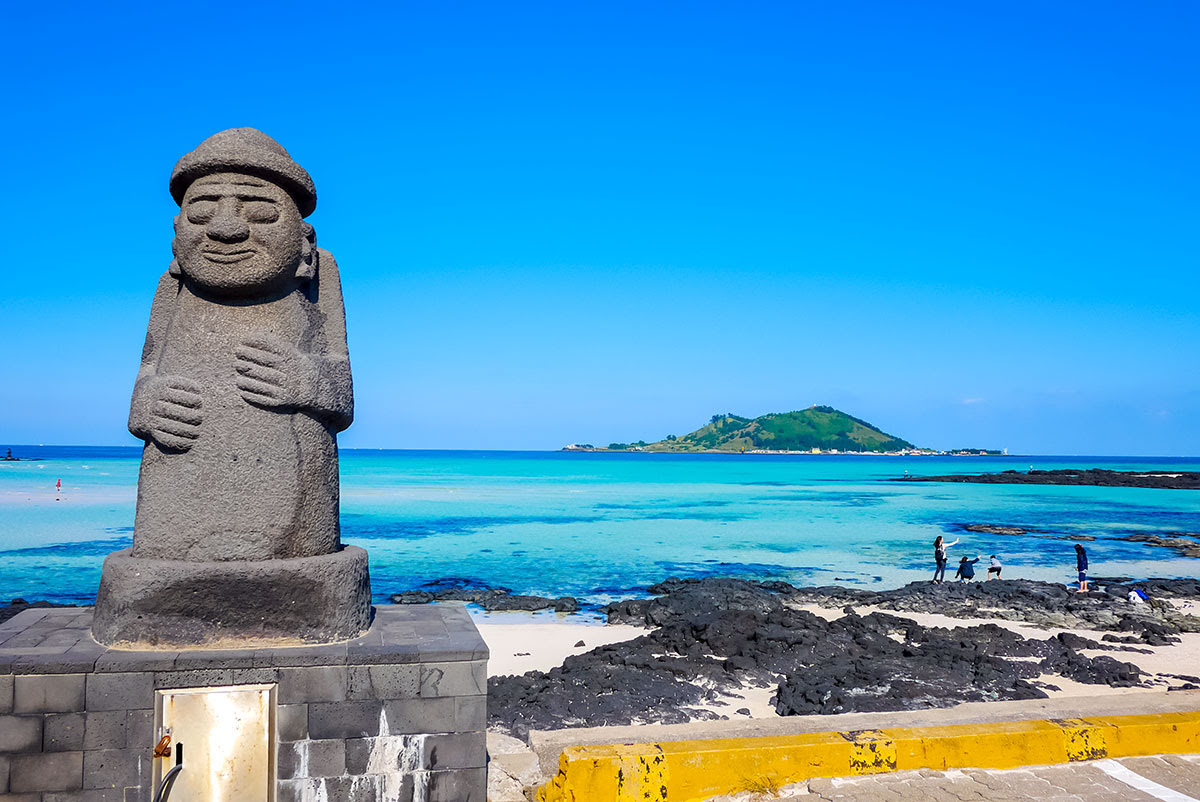

In [6]:
img

In [7]:
# content와 style 이미지 불러오기
from PIL import Image
#path2content = './univ.jpg'
path2style = './styles2.jpg'

#content_img = Image.open(path2content)
style_img = Image.open(path2style)
content_img= Image.open(img)


AttributeError: read

In [8]:
content_img

NameError: name 'content_img' is not defined

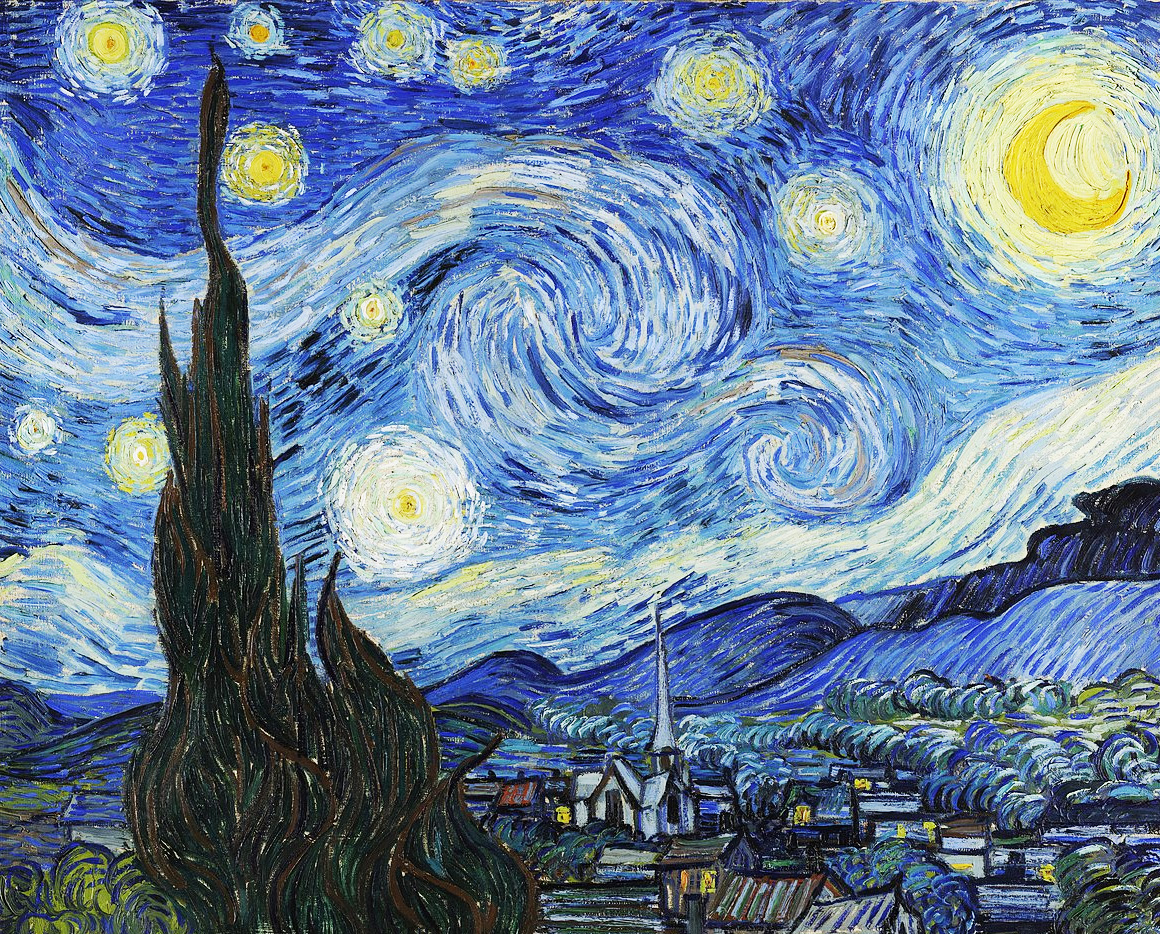

In [9]:
style_img

In [10]:
import torchvision.transforms as transforms

h, w = 256, 384
mean_rgb = (0.485, 0.456, 0.406)
std_rgb = (0.229, 0.224, 0.225)

transformer = transforms.Compose([
                transforms.Resize((h,w)),
                transforms.ToTensor(),
                transforms.Normalize(mean_rgb, std_rgb)
])

In [11]:
# 이미지에 transformation 적용하기
content_tensor = transformer(content_img)
style_tensor = transformer(style_img)
print(content_tensor.shape, content_tensor.requires_grad)
print(style_tensor.shape, style_tensor.requires_grad)

NameError: name 'content_img' is not defined

In [ ]:
# transformation이 적용된 image 시각화하기
import torch

def imgtensor2pil(img_tensor):
    img_tensor_c = img_tensor.clone().detach()
    img_tensor_c *= torch.tensor(std_rgb).view(3, 1,1)
    img_tensor_c += torch.tensor(mean_rgb).view(3,1,1)
    img_tensor_c = img_tensor_c.clamp(0,1)
    img_pil = to_pil_image(img_tensor_c)
    return img_pil

In [ ]:

import matplotlib.pyplot as plt
%matplotlib inline
from torchvision.transforms.functional import to_pil_image

fig=plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(imgtensor2pil(content_tensor))
plt.subplot(1,2,2)
plt.imshow(imgtensor2pil(style_tensor))
fig.savefig('univ-monk.png', dpi=200)

In [ ]:
# pretrained VGG19를 불러옵니다
import torchvision.models as models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_vgg = models.vgg19(pretrained=True).features.to(device).eval()

# 파라미터를 freeze 합니다.
for param in model_vgg.parameters():
    param.requires_grad_(False)

In [ ]:
model_vgg

In [ ]:
# style loss와 content loss를 정의하기 위해 
# 모델의 중간 feature를 얻은 후 Gram matrix를 계산해야 합니다.

# 모델의 중간 레이어의 출력값을 얻는 함수를 정의합니다.
def get_features(x, model, layers):
    features = {}
    for name, layer in enumerate(model.children()): # 0, conv
        x = layer(x)
        if str(name) in layers:
            features[layers[str(name)]] = x
    return features
     

In [ ]:
# Gram matrix를 계산하는 함수를 정의합니다.
def gram_matrix(x):
    n, c, h, w = x.size()
    x = x.view(n*c, h*w) #텐서를 (n*c, h*w) 로 변환
    gram = torch.mm(x,x.t()) # 행렬간 곱셈 수행
    return gram

In [ ]:

# content loss를 계산하는 함수를 정의합니다.
import torch.nn.functional as F

def get_content_loss(pred_features, target_features, layer):
    target = target_features[layer]
    pred = pred_features[layer]
    loss = F.mse_loss(pred, target)
    return loss
     

In [ ]:

# style loss
def get_style_loss(pred_features, target_features, style_layers_dict):
    loss = 0
    for layer in style_layers_dict:
        pred_fea = pred_features[layer]
        pred_gram = gram_matrix(pred_fea)
        n, c, h, w = pred_fea.shape
        target_gram = gram_matrix(target_features[layer])
        layer_loss = style_layers_dict[layer] * F.mse_loss(pred_gram, target_gram)
        loss += layer_loss / (n*c*h*w)
    return loss
     

In [ ]:
# content와 style image를 위한 feature를 얻습니다.
feature_layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '28': 'conv5_1'}

con_tensor = content_tensor.unsqueeze(0).to(device)
sty_tensor = style_tensor.unsqueeze(0).to(device)

content_features = get_features(con_tensor, model_vgg, feature_layers)
style_features = get_features(sty_tensor, model_vgg, feature_layers)

In [ ]:

# content tensor을 복사한 input tensor을 생성합니다.
#input_tensor = con_tensor.clone().requires_grad_(True)

#랜덤노이즈로 변경
#input_tensor=torch.randn(input_tensor.size()).to(device)

#스타일 이미지로 변경
input_tensor=sty_tensor.clone().requires_grad_(True)
# optimizer를 정의합니다.
from torch import optim
optimizer = optim.Adam([input_tensor], lr=0.01)

In [ ]:
# 하이퍼파라미터
num_epochs = 10000
content_weight = 5e4
style_weight = 1e2
content_layer = 'conv5_1'
style_layers_dict = {'conv1_1':0.75, #0.75
                     'conv2_1':0.5, #0.5
                     'conv3_1':0.25, #0.25
                     'conv4_1':0.25, #0.25
                     'conv5_1':0.25} #0.25

In [ ]:
# style transfer
for epoch in range(num_epochs+1):
    optimizer.zero_grad()
    input_features = get_features(input_tensor, model_vgg, feature_layers) # feature_layers에 해당하는 layer의 출력값 얻기
    content_loss = get_content_loss(input_features, content_features, content_layer) # 
    style_loss = get_style_loss(input_features, style_features, style_layers_dict)
    neural_loss = content_weight * content_loss + style_weight * style_loss
    neural_loss.backward(retain_graph=True)
    optimizer.step()
    if epoch % 100 == 0:
        print('epoch {}, content loss: {:.2}, style loss: {:.2}'.format(epoch, content_loss, style_loss))

In [12]:
# 결과 시각화
plt.imshow(imgtensor2pil(input_tensor[0].cpu()))
plt.savefig('starrynight2monk.png', dpi=300)

NameError: name 'plt' is not defined